## A Proportionate Stratified Random Sample of the French Comdies

In this notebook, we take a proportionate stratified random sample of 10% of each strata:
- First, we load all json files and the metadata file
- Create five-year and ten-year intervals
- Examine the counts for each interval
- Determine which time interval is more appropriate (five or ten years) to form our strata
- Take 10% sample of each strata
- Save the sample for future analysis

In [1]:
import json
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            data['metadata']['speech_distribution'] = np.array(data['metadata']['speech_distribution'])
            df = pd.DataFrame(data['metadata'].values()).T
            df.columns = data['metadata'].keys()
            df['index'] = file.replace('.json','')
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False)
    
    return features_df

In [3]:
def five_year_intervals(n):
    return n + (5 - n) % 5

In [4]:
def ten_year_intervals(n):
    return n + (10 - n) % 10

In [5]:
def combine_with_meta(input_directory, features_df):
    metadata_df = pd.read_csv(input_directory, sep='\t')
    all_data_df = metadata_df.merge(features_df, how='left', on='index')
    all_data_df = all_data_df.sort_values(by='date')
    all_data_df['translation/adaptation/contrastive'] = all_data_df['translation/adaptation/contrastive'].fillna(0)
    all_data_df['translation/adaptation/contrastive'] = all_data_df['translation/adaptation/contrastive'].astype(int)
    all_data_df['five_year_intervals'] = all_data_df['date'].apply(five_year_intervals)
    all_data_df['decades'] = all_data_df['date'].apply(ten_year_intervals)
    
    return all_data_df

In [6]:
all_data_df = combine_with_meta('../French_Comedies/French_Comedies.tsv',
                               get_data('../French_Comedies/Play_Jsons'))

In [7]:
all_data_df.to_csv('../French_Comedies/Data/French_Comedies_Data.csv', index=False)

In [8]:
# select the plays that are not translations or adaptations or the comedies we decided to include in the contrastive
# material
original_df = all_data_df[(all_data_df['translation/adaptation/contrastive'] != 1)& 
                          (all_data_df['index'] != 'F_1') & (all_data_df['num_acts'] == 5)].copy()

In [9]:
original_df.shape

(259, 25)

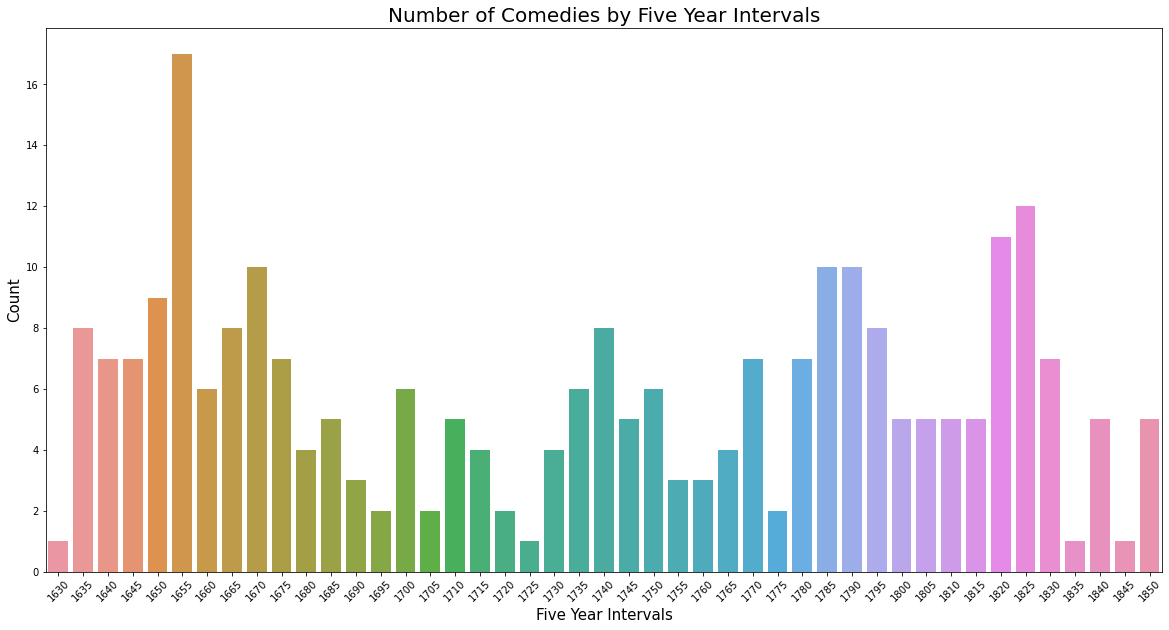

In [10]:
plt.figure(figsize=(20, 10))
plt.title('Number of Comedies by Five Year Intervals', fontsize=20)
sns.countplot(original_df['five_year_intervals'])
plt.xlabel('Five Year Intervals', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=45)
plt.show()

It looks like five year intervals do not always contain enough data to sample from: there are quite a few intervals with les than two plays. Therefore, we will examine decades.

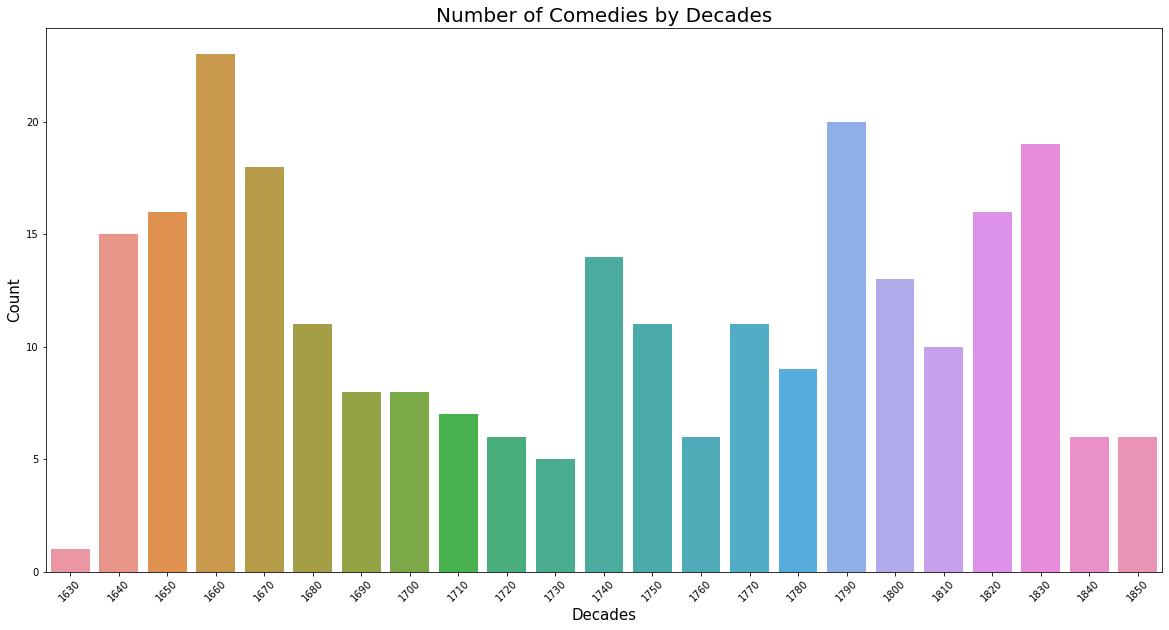

In [11]:
plt.figure(figsize=(20, 10))
plt.title('Number of Comedies by Decades', fontsize=20)
sns.countplot(original_df['decades'])
plt.xlabel('Decades', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [12]:
counts = original_df['decades'].value_counts()

In [13]:
def sample_data(data_df, column, fraction):
    """
    The function creates a stratified sample.
    Params:
        data_df - dataframe with data from which we want to create a sample
        column - which date range we will use, e.g. decades or five_year_intervals
        fraction - which fraction we want to sample, e.g. 0.1
    Returns:
        sample_df - a proportionate stratified random sample
    """
    counts = data_df[column].value_counts()
    samples = []
    for combo in zip(counts.index.tolist(), counts.values.tolist()):
        # we noticed that we have one decade with only five comedies, in this case we will sample 1 play
        if combo[1] == 5:
            sample_size = 1
        # sample 10%
        else:
            sample_size = int(round(combo[1] * fraction, 0))
        samples.append(original_df[original_df[column] == combo[0]].sample(sample_size))
    sample_df = pd.concat(samples, axis=0)
    
    return sample_df

In [14]:
sample_df = sample_data(original_df, 'decades', 0.1)

In [15]:
sample_df.shape

(29, 25)

In [16]:
sample_df.to_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv', index=False)